In [2]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA version in PyTorch:", torch.version.cuda)   # None if CPU-only
print("CUDA available?", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
    print("Compute capability:", torch.cuda.get_device_capability())

# Also check build info
print("\nCompiled with CUDA:", torch.backends.cudnn.enabled if torch.cuda.is_available() else False)
print("cuDNN version:", torch.backends.cudnn.version() if torch.cuda.is_available() else "N/A")

PyTorch version: 2.5.1+cu121
CUDA version in PyTorch: 12.1
CUDA available? True
Number of GPUs: 1
GPU name: NVIDIA GeForce RTX 4050 Laptop GPU
Compute capability: (8, 9)

Compiled with CUDA: True
cuDNN version: 90100


In [4]:
import os
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import random


from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from gensim.models import KeyedVectors
from TorchCRF import CRF
from collections import Counter
from tqdm import tqdm
import seaborn as sns




SEED = 42

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


# Dataset

In [6]:
from utils.fonctions import (
    load_jnlpba_dataset,
    load_ncbi_dataset,
    prepare_ncbi_for_ner
)

jnlpba_data, _ = load_jnlpba_dataset("./datasets/JNLPBA")

ncbi_raw = load_ncbi_dataset("./datasets/NCBI-Corpus/")
ncbi_data = prepare_ncbi_for_ner(ncbi_raw)

print("JNLPBA:", len(jnlpba_data))
print("NCBI:", len(ncbi_data))

Chargement du dataset JNLPBA depuis: ./datasets/JNLPBA
- sentences: 22402 phrases
- 11 Classes: ['B-DNA', 'I-DNA', 'B-cell_line', 'I-cell_line', 'B-protein', 'I-protein', 'B-cell_type', 'I-cell_type', 'B-RNA', 'I-RNA', 'O']
Chargement du dataset NCBI depuis: ./datasets/NCBI-Corpus/
Documents chargés: 793
Exemple d'entités dans le premier document: 2
Total de phrases générées (format JNLPBA): 7524

Vérification du format:
Type du premier élément: <class 'tuple'>
Longueur du tuple: 2
Type tokens: <class 'list'> (longueur: 16)
Type labels: <class 'list'> (longueur: 16)
Exemple tokens[:5]: ['Germline', 'mutations', 'in', 'BRCA1', 'are']
Exemple labels[:5]: ['O', 'O', 'O', 'O', 'O']
JNLPBA: 22402
NCBI: 7524


In [7]:
print("=== JNLPBA SAMPLE ===\n")

for i, sent in enumerate(jnlpba_data[:2]):
    print(f"Sentence {i+1}:")
    print(sent)
    print()

=== JNLPBA SAMPLE ===

Sentence 1:
[('IL-2', 'B-DNA'), ('gene', 'I-DNA'), ('expression', 'O'), ('and', 'O'), ('NF-kappa', 'B-protein'), ('B', 'I-protein'), ('activation', 'O'), ('through', 'O'), ('CD28', 'B-protein'), ('requires', 'O'), ('reactive', 'O'), ('oxygen', 'O'), ('production', 'O'), ('by', 'O'), ('5-lipoxygenase', 'B-protein'), ('.', 'O')]

Sentence 2:
[('Activation', 'O'), ('of', 'O'), ('the', 'O'), ('CD28', 'B-protein'), ('surface', 'I-protein'), ('receptor', 'I-protein'), ('provides', 'O'), ('a', 'O'), ('major', 'O'), ('costimulatory', 'O'), ('signal', 'O'), ('for', 'O'), ('T', 'O'), ('cell', 'O'), ('activation', 'O'), ('resulting', 'O'), ('in', 'O'), ('enhanced', 'O'), ('production', 'O'), ('of', 'O'), ('interleukin-2', 'B-protein'), ('(', 'O'), ('IL-2', 'B-protein'), (')', 'O'), ('and', 'O'), ('cell', 'O'), ('proliferation', 'O'), ('.', 'O')]



In [8]:
print("=== NCBI SAMPLE ===\n")

for i, sent in enumerate(ncbi_data[:2]):
    print(f"Sentence {i+1}:")
    print(sent)
    print()

=== NCBI SAMPLE ===

Sentence 1:
(['Germline', 'mutations', 'in', 'BRCA1', 'are', 'responsible', 'for', 'most', 'cases', 'of', 'inherited', 'breast', 'and', 'ovarian', 'cancer', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention'])

Sentence 2:
(['However', ',', 'the', 'function', 'of', 'the', 'BRCA1', 'protein', 'has', 'remained', 'elusive', '.'], ['I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'O', 'O', 'O', 'O', 'O'])



In [9]:
def get_all_labels(data):
    labels = set()

    for sent in data:
        # CASE 1: list of (token, label)
        if isinstance(sent, list) and isinstance(sent[0], tuple):
            for _, lab in sent:
                labels.add(lab)

        # CASE 2: (tokens, labels)
        elif isinstance(sent, (list, tuple)) and len(sent) == 2:
            _, labs = sent
            for lab in labs:
                labels.add(lab)

        else:
            raise TypeError("Unknown sentence format")

    return sorted(labels)

In [10]:
print("=== JNLPBA CLASSES ===")
print(get_all_labels(jnlpba_data))

print("\n=== NCBI CLASSES ===")
print(get_all_labels(ncbi_data))

=== JNLPBA CLASSES ===
['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']

=== NCBI CLASSES ===
['B-CompositeMention', 'B-DiseaseClass', 'B-Modifier', 'B-SpecificDisease', 'I-CompositeMention', 'I-DiseaseClass', 'I-Modifier', 'I-SpecificDisease', 'O']


In [12]:
def count_entities(dataset):
    """
    Count entity occurrences in a dataset.
    dataset: list of sentences, each sentence is a list of (word, label) tuples
    Returns:
        entity_counter: Counter with counts per entity label (excluding 'O')
        total_sentences: total number of sentences processed
    """
    if not dataset or not isinstance(dataset, list):
        raise TypeError("Dataset should be a list of sentences")

    entity_counter = Counter()
    total_sentences = 0

    for sent in dataset:
        if not sent or not isinstance(sent, list):
            continue  # skip invalid sentence
        total_sentences += 1
        for token in sent:
            if isinstance(token, tuple) and len(token) == 2:
                word, label = token
                if label != "O":
                    entity_counter[label] += 1
            else:
                raise TypeError("Each token should be a tuple: (word, label)")

    return entity_counter, total_sentences


### JNLBA

In [13]:
jnlpba_entities, jnlpba_sentences = count_entities(jnlpba_data)

print("\n=== JNLPBA ENTITY DISTRIBUTION ===")
for ent, count in jnlpba_entities.most_common():
    print(f"{ent:<25} {count}")
print(" = Total sentences:", jnlpba_sentences)


=== JNLPBA ENTITY DISTRIBUTION ===
B-protein                 35336
I-protein                 29622
I-DNA                     17563
I-cell_type               11739
B-DNA                     10589
B-cell_type               8639
I-cell_line               8376
B-cell_line               4330
I-RNA                     1717
B-RNA                     1069
 = Total sentences: 22402


### NCBI

In [14]:
ncbi_token_label = [list(zip(tokens, labels)) for tokens, labels in ncbi_data]
ncbi_entities, ncbi_sent_count = count_entities(ncbi_token_label)


ncbi_entities, ncbi_sent_count = count_entities(ncbi_token_label)

print("\n=== NCBI ENTITY DISTRIBUTION ===")
for ent, count in ncbi_entities.most_common():
    print(f"{ent:<25} {count}")
print(" = Total sentences:", ncbi_sent_count)




=== NCBI ENTITY DISTRIBUTION ===
I-SpecificDisease         18802
I-Modifier                7579
I-DiseaseClass            5294
B-SpecificDisease         3338
B-Modifier                1500
I-CompositeMention        1436
B-DiseaseClass            950
B-CompositeMention        151
 = Total sentences: 7524


### Dataset Summary

In [15]:
def dataset_summary(name, data, entities):
    print(f"\n{name} SUMMARY")
    print(f"Sentences        : {len(data)}")
    print(f"Entity classes   : {len(entities)}")
    print(f"Total entities   : {sum(entities.values())}")

dataset_summary("JNLPBA", jnlpba_data, jnlpba_entities)
dataset_summary("NCBI", ncbi_data, ncbi_entities)


JNLPBA SUMMARY
Sentences        : 22402
Entity classes   : 10
Total entities   : 128980

NCBI SUMMARY
Sentences        : 7524
Entity classes   : 8
Total entities   : 39050


## NORMALIZATION

In [16]:
def normalize_dataset(dataset):
    out = []
    for sent in dataset:
        s = []
        for w, l in sent:
            w = w.strip()
            if not w:
                w = "<UNK>"
            elif w.isdigit():
                w = "<NUM>"
            l = l.strip()
            s.append((w, l))
        out.append(s)
    return out


jnlpba_data = normalize_dataset(jnlpba_data)

ncbi_data = [list(zip(tokens, labels)) for tokens, labels in ncbi_data]

# Now normalize
ncbi_data = normalize_dataset(ncbi_data)

C:\Users\oumak\AppData\Local\Temp\ipykernel_25188\3096731626.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(counter1.keys(), rotation=45, ha='right')
C:\Users\oumak\AppData\Local\Temp\ipykernel_25188\3096731626.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(counter2.keys(), rotation=45, ha='right')


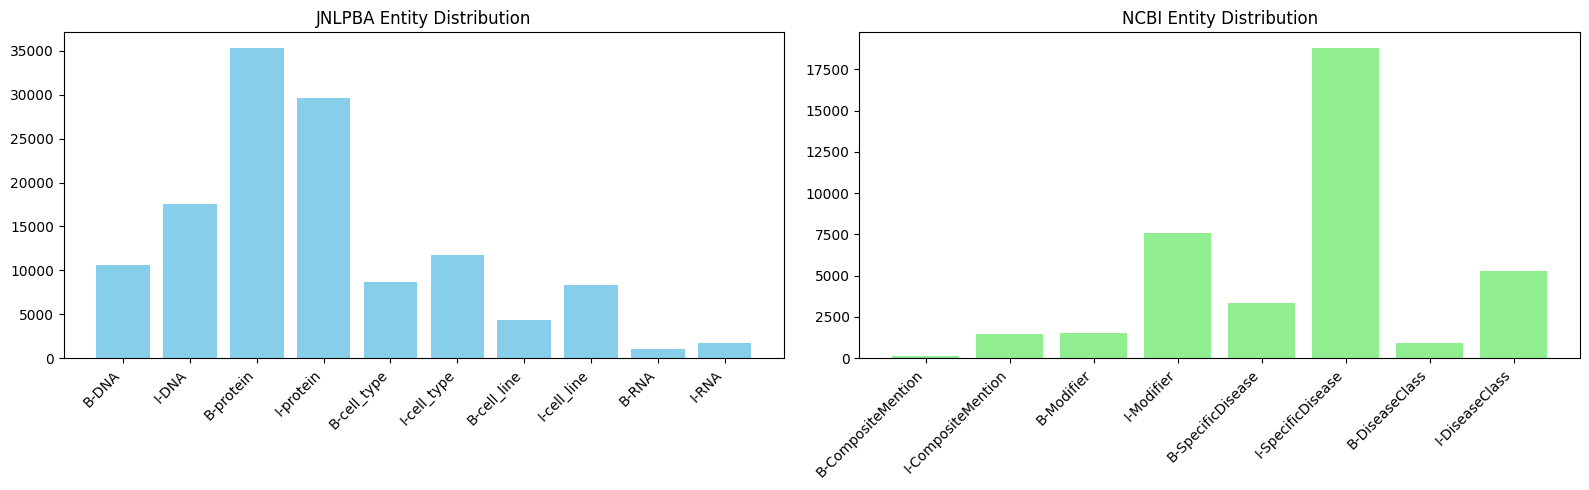

In [17]:
def plot_entity_distributions_side_by_side(counter1, counter2, labels=("JNLPBA", "NCBI")):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # 1 row, 2 columns

    # First dataset
    axes[0].bar(counter1.keys(), counter1.values(), color='skyblue')
    axes[0].set_xticklabels(counter1.keys(), rotation=45, ha='right')
    axes[0].set_title(f"{labels[0]} Entity Distribution")

    # Second dataset
    axes[1].bar(counter2.keys(), counter2.values(), color='lightgreen')
    axes[1].set_xticklabels(counter2.keys(), rotation=45, ha='right')
    axes[1].set_title(f"{labels[1]} Entity Distribution")

    plt.tight_layout()
    plt.show()


# Get entity counts
entities_jnlpba, _ = count_entities(jnlpba_data)
entities_ncbi, _ = count_entities(ncbi_data)

# Plot side by side
plot_entity_distributions_side_by_side(entities_jnlpba, entities_ncbi)

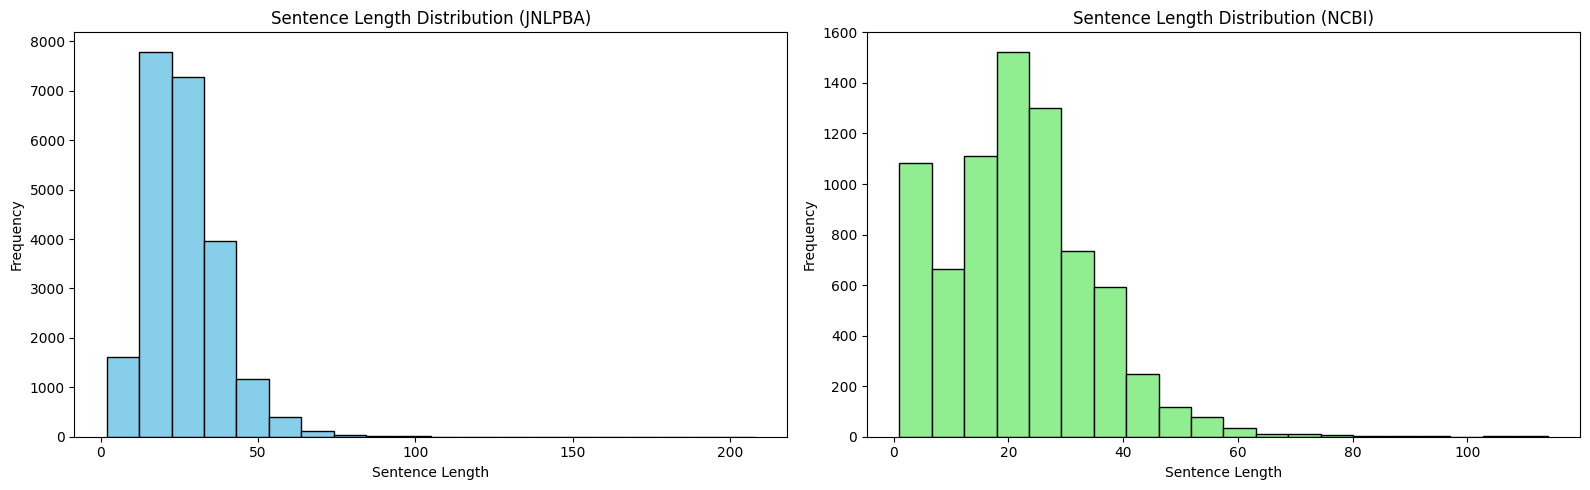

In [18]:
# Get sentence lengths
lengths_jnlpba = [len(s) for s in jnlpba_data]
lengths_ncbi = [len(s) for s in ncbi_data]

# Create side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # 1 row, 2 columns

# JNLPBA histogram
axes[0].hist(lengths_jnlpba, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title("Sentence Length Distribution (JNLPBA)")
axes[0].set_xlabel("Sentence Length")
axes[0].set_ylabel("Frequency")

# NCBI histogram
axes[1].hist(lengths_ncbi, bins=20, color='lightgreen', edgecolor='black')
axes[1].set_title("Sentence Length Distribution (NCBI)")
axes[1].set_xlabel("Sentence Length")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## VOCABULARIES

In [19]:
def build_word_vocab(data):
    counter = Counter(w for sent in data for w, _ in sent)
    vocab = {"<PAD>": 0, "<UNK>": 1, "<NUM>": 2}  # <-- add <NUM>
    for w in counter:
        if w not in vocab:
            vocab[w] = len(vocab)
    return vocab


def build_char_vocab(data):
    chars = set(c for sent in data for w, _ in sent for c in w)
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for c in chars:
        vocab[c] = len(vocab)
    return vocab


def build_label_vocab(data):
    labels = sorted(set(l for sent in data for _, l in sent))
    vocab = {"<PAD>": 0}
    for l in labels:
        vocab[l] = len(vocab)
    return vocab

all_data = jnlpba_data + ncbi_data

word_vocab  = build_word_vocab(all_data)
char_vocab  = build_char_vocab(all_data)
label_vocab_jnlpba = build_label_vocab(jnlpba_data)
label_vocab_ncbi   = build_label_vocab(ncbi_data)


print("Word vocab:", len(word_vocab))
print("Char vocab:", len(char_vocab))
print("Labels JNLPBA:", label_vocab_jnlpba)
print("Labels NCBI:", label_vocab_ncbi)

Word vocab: 30243
Char vocab: 88
Labels JNLPBA: {'<PAD>': 0, 'B-DNA': 1, 'B-RNA': 2, 'B-cell_line': 3, 'B-cell_type': 4, 'B-protein': 5, 'I-DNA': 6, 'I-RNA': 7, 'I-cell_line': 8, 'I-cell_type': 9, 'I-protein': 10, 'O': 11}
Labels NCBI: {'<PAD>': 0, 'B-CompositeMention': 1, 'B-DiseaseClass': 2, 'B-Modifier': 3, 'B-SpecificDisease': 4, 'I-CompositeMention': 5, 'I-DiseaseClass': 6, 'I-Modifier': 7, 'I-SpecificDisease': 8, 'O': 9}


## ENCODING

In [20]:
MAX_CHAR_LEN = 30

def encode(sent, word_vocab, char_vocab, label_vocab):
    words, chars, labels = [], [], []
    for w, l in sent:
        # word index
        words.append(word_vocab.get(w, word_vocab["<UNK>"]))

        # char indices with padding
        c = [char_vocab.get(ch, char_vocab["<UNK>"]) for ch in w][:MAX_CHAR_LEN]
        c += [char_vocab["<PAD>"]] * (MAX_CHAR_LEN - len(c))
        chars.append(c)

        # label index
        labels.append(label_vocab[l])

    return {
        "words": words,
        "chars": chars,
        "labels": labels
    }

In [21]:
# For JNLPBA
encoded_jnlpba = [encode(sent, word_vocab, char_vocab, label_vocab_jnlpba) for sent in jnlpba_data]

# For NCBI
encoded_ncbi = [encode(sent, word_vocab, char_vocab, label_vocab_ncbi) for sent in ncbi_data]

print("Example encoding JNLPBA:", encoded_jnlpba[0])
print("Example encoding NCBI:", encoded_ncbi[0])


Example encoding JNLPBA: {'words': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], 'chars': [[55, 51, 44, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [67, 62, 56, 62, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [62, 35, 7, 9, 62, 29, 29, 18, 3, 56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [45, 56, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [71, 24, 44, 31, 45, 7, 7, 45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [45, 50, 54, 18, 61, 45, 54, 18, 3, 56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [54, 19, 9, 3, 37, 67, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [78, 72, 17, 39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [9, 62, 79, 37, 18, 9, 62

## Encode + Split

In [23]:
random.shuffle(encoded_jnlpba)
n_total_jnlpba = len(encoded_jnlpba)
train_end_jnlpba = int(0.8 * n_total_jnlpba)
val_end_jnlpba = int(0.9 * n_total_jnlpba)

train_data_jnlpba = encoded_jnlpba[:train_end_jnlpba]
val_data_jnlpba   = encoded_jnlpba[train_end_jnlpba:val_end_jnlpba]
test_data_jnlpba  = encoded_jnlpba[val_end_jnlpba:]

print("Train:", len(train_data_jnlpba), "Val:", len(val_data_jnlpba), "Test:", len(test_data_jnlpba))


random.shuffle(encoded_ncbi)
n_total_ncbi = len(encoded_ncbi)
train_end_ncbi = int(0.8 * n_total_ncbi)
val_end_ncbi = int(0.9 * n_total_ncbi)

train_data_ncbi = encoded_ncbi[:train_end_ncbi]
val_data_ncbi   = encoded_ncbi[train_end_ncbi:val_end_ncbi]
test_data_ncbi  = encoded_ncbi[val_end_ncbi:]

print("Train:", len(train_data_ncbi), "Val:", len(val_data_ncbi), "Test:", len(test_data_ncbi))


Train: 17921 Val: 2240 Test: 2241
Train: 6019 Val: 752 Test: 753


## DATASET & COLLATE

In [24]:
class NERDataset(Dataset):
    def __init__(self, data): self.data = data
    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i]

def collate(batch):
    max_len = max(len(x["words"]) for x in batch)
    pad = lambda x, v: x + [v] * (max_len - len(x))
    words = [pad(x["words"], 0) for x in batch]
    labels = [pad(x["labels"], 0) for x in batch]
    chars = [x["chars"] + [[0]*MAX_CHAR_LEN]*(max_len-len(x["chars"])) for x in batch]
    mask = [[1]*len(x["words"]) + [0]*(max_len-len(x["words"])) for x in batch]

    return (
        torch.tensor(words),
        torch.tensor(chars),
        torch.tensor(labels),
        torch.tensor(mask, dtype=torch.bool)
    )


train_loader_jnlpba = DataLoader(NERDataset(train_data_jnlpba), batch_size=4, shuffle=True, collate_fn=collate)
val_loader_jnlpba   = DataLoader(NERDataset(val_data_jnlpba), batch_size=4, shuffle=False, collate_fn=collate)
test_loader_jnlpba  = DataLoader(NERDataset(test_data_jnlpba), batch_size=4, shuffle=False, collate_fn=collate)


train_loader_ncbi = DataLoader(NERDataset(train_data_ncbi), batch_size=4, shuffle=True, collate_fn=collate)
val_loader_ncbi   = DataLoader(NERDataset(val_data_ncbi), batch_size=4, shuffle=False, collate_fn=collate)
test_loader_ncbi  = DataLoader(NERDataset(test_data_ncbi), batch_size=4, shuffle=False, collate_fn=collate)

## Word Embedding with  BioWordVec

In [25]:
print("Loading PubMed/BioWordVec embeddings...")

embedding_path = './embeddings/BioWordVec_PubMed_MIMICIII_d200.vec.bin'

if not os.path.exists('./embeddings/biowordvec.gensim'):
    word2vec = KeyedVectors.load_word2vec_format(
        embedding_path, 
        binary=True, 
        limit=None, 
        unicode_errors='ignore'
    )
    word2vec.save('./embeddings/biowordvec.gensim')

print("PubMed/BioWordVec embeddings loaded successfully")

Loading PubMed/BioWordVec embeddings...
PubMed/BioWordVec embeddings loaded successfully


In [26]:
kv = KeyedVectors.load("./embeddings/biowordvec.gensim", mmap="r")
EMB_DIM = kv.vector_size
print(EMB_DIM)

emb_matrix = np.random.normal(0, 0.6, (len(word_vocab), EMB_DIM))
for w, i in word_vocab.items():
    if w in kv:
        emb_matrix[i] = kv[w]

word_embeddings = nn.Embedding.from_pretrained(
    torch.tensor(emb_matrix, dtype=torch.float),
    freeze=True  # freeze pre-trained embeddings
)

# Allow UNK and NUM to be trainable by setting requires_grad=True for their indices:

unk_idx = word_vocab["<UNK>"]
num_idx = word_vocab.get("<NUM>", None)

word_embeddings.weight[unk_idx].requires_grad = True
if num_idx is not None:
    word_embeddings.weight[num_idx].requires_grad = True

200


In [27]:
for w in ["protein", "gene", "cell"]:
    idx = word_vocab.get(w, word_vocab["<UNK>"])
    print(f"{w} embedding[:5]:", word_embeddings.weight[idx][:5])

protein embedding[:5]: tensor([ 0.4470,  0.1808,  0.8673,  0.0670, -0.4816])
gene embedding[:5]: tensor([ 0.4091,  0.2587,  0.6041,  0.5961, -0.3054])
cell embedding[:5]: tensor([ 0.3164,  0.5183,  0.1831, -0.2114, -0.4252])


## Char Encoders

In [28]:
CHAR_EMB_DIM = 100

class CharCNN(nn.Module):
    def __init__(self, filter_sizes=(3,5,7)):
        super().__init__()

        self.emb = nn.Embedding(len(char_vocab), CHAR_EMB_DIM, padding_idx=0)

        self.convs = nn.ModuleList([
            nn.Conv1d(CHAR_EMB_DIM, 50, k, padding=k//2) for k in filter_sizes
        ])


    def forward(self, x):
        B, T, L = x.shape
        x = self.emb(x).view(B*T, L, -1).transpose(1,2)
        feats = [torch.max(torch.relu(conv(x)), 2)[0] for conv in self.convs]
        return torch.cat(feats, 1).view(B, T, -1)



class CharBiLSTM(nn.Module):
    def __init__(self):
        super().__init__()

        self.emb = nn.Embedding(len(char_vocab), CHAR_EMB_DIM, padding_idx=0)

        self.lstm = nn.LSTM(CHAR_EMB_DIM, 50, bidirectional=True, batch_first=True)


    def forward(self, x):
        B, T, L = x.shape
        x = self.emb(x).view(B*T, L, -1)
        _, (h, _) = self.lstm(x)
        return torch.cat([h[0], h[1]], 1).view(B, T, -1)

## MANHATTAN ATTENTION

In [29]:
class ManhattanAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.W = nn.Linear(dim, 1, bias=False)

    def forward(self, h, mask):
        B, T, D = h.shape
        hi = h.unsqueeze(2).expand(B, T, T, D)
        hj = h.unsqueeze(1).expand(B, T, T, D)
        dist = torch.abs(hi - hj).sum(-1)
        score = -self.W(hj).squeeze(-1) * dist
        score = score.masked_fill(~mask.unsqueeze(1), -1e9)
        alpha = torch.softmax(score, -1)
        ctx = torch.matmul(alpha, h)
        return torch.cat([h, ctx], -1)

## FULL MODEL

In [30]:
class BioNER(nn.Module):
    def __init__(self, label_vocab, fc_activation=None):
        super().__init__()
        self.word_emb = word_embeddings
        if label_vocab == label_vocab_ncbi :
            self.char_cnn = CharCNN(filter_sizes=[2, 3, 4])
        else :
            self.char_cnn = CharCNN()
        self.char_lstm = CharBiLSTM()

        concat_dim = EMB_DIM + 150 + 100
        self.embed_fc = nn.Linear(concat_dim, 200)
        self.fc_activation = fc_activation  # None for JNLPBA, ReLU for NCBI

        self.dropout = nn.Dropout(0.5)
        
        # ----- BiLSTM -----
        if label_vocab == label_vocab_ncbi:
            self.lstm_hidden = 128
        else:
            self.lstm_hidden = 256

        self.bilstm = nn.LSTM(
            200,
            self.lstm_hidden,
            bidirectional=True,
            batch_first=True
        )

        self.lstm_out_dim = 2 * self.lstm_hidden

        # ----- Attention & FC -----
        self.attn = ManhattanAttention(self.lstm_out_dim)
        self.fc = nn.Linear(2 * self.lstm_out_dim, len(label_vocab))

        self.crf = CRF(len(label_vocab), batch_first=True)


    def forward(self, w, c, mask, labels=None):
        we = self.word_emb(w)
        ce1 = self.dropout(self.char_cnn(c))
        ce2 = self.dropout(self.char_lstm(c))

        x = torch.cat([we, ce1, ce2], -1)
        x = self.embed_fc(x)
        if self.fc_activation is not None:
            x = self.fc_activation(x)
        x = self.dropout(x)

        h, _ = self.bilstm(x)
        h = self.dropout(h[:, :, :])
        h = self.attn(h, mask)
        emissions = self.fc(h)

        if labels is not None:
            labels = labels.clone()
            labels[~mask] = 0
            return -self.crf(emissions, labels, mask)

        return self.crf.decode(emissions, mask)


## TRAINING & METRICS

In [65]:
def metrics(y_true, y_pred):
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average="micro")
    acc = sum(t == p for t, p in zip(y_true, y_pred)) / len(y_true)
    return acc, p, r, f

def evaluate(model, loader):
    model.eval()
    loss, yt, yp = 0, [], []
    with torch.no_grad():
        for w, c, l, m in loader:
            w, c, l, m = w.to(device), c.to(device), l.to(device), m.to(device)
            loss += model(w, c, m, l).item()
            preds = model(w, c, m)
            for p, g, mask in zip(preds, l, m):
                L = mask.sum().item()
                yp.extend(p[:L])
                yt.extend(g[:L].tolist())
    acc, p, r, f = metrics(yt, yp)
    return loss/len(loader), acc, p, r, f

In [66]:
def entity_accuracy(y_true, y_pred, o_label_idx):
    """
    Compute accuracy ignoring the 'O' label (and optionally padding 0)
    """
    correct, total = 0, 0
    for t, p in zip(y_true, y_pred):
        if t != o_label_idx and t != 0:  # ignore 'O' and PAD
            total += 1
            if t == p:
                correct += 1
    return correct / total if total > 0 else 0.0


In [ ]:
def compute_prf(y_true, y_pred, labels=None):
    """
    Token-level PRF (micro) excluding padding.
    """
    p, r, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average="micro",
        labels=labels,
        zero_division=0
    )
    return p, r, f1


## TRAIN LOOP

### For JNLPBA

In [ ]:
# -----------------------------
# Model, device
# -----------------------------
model = BioNER(label_vocab=label_vocab_jnlpba, fc_activation=None).to(device)

# -----------------------------
# Optimizer + L2 weight decay
# -----------------------------
l2_lambda = 5e-4
decay_params, no_decay_params = [], []

for name, param in model.named_parameters():
    if not param.requires_grad:
        continue
    if "bias" in name or "word_emb" in name or "crf" in name:
        no_decay_params.append(param)
    else:
        decay_params.append(param)

opt = optim.Adam(
    [
        {"params": decay_params, "weight_decay": l2_lambda},
        {"params": no_decay_params, "weight_decay": 0.0},
    ],
    lr=1e-3
)

scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.90)

# -----------------------------
# Training loop with tqdm
# -----------------------------
best_val_f1 = 0
wait = 0
patience = 4
num_epochs = 40

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # ---- training ----
    model.train()
    tr_loss = 0.0
    n_batches = 0

    train_iter = tqdm(train_loader_jnlpba, desc="Training", leave=False)
    for w, c, l, m in train_iter:
        w, c, l, m = w.to(device), c.to(device), l.to(device), m.to(device)

        opt.zero_grad()
        loss = model(w, c, m, l)  # forward with labels
        loss.backward()
        opt.step()

        tr_loss += loss.item()
        n_batches += 1

        train_iter.set_postfix({"Batch Loss": loss.item()})

    tr_loss /= n_batches

    # ---- validation ----
    model.eval()
    val_loss = 0.0
    yt_val, yp_val = [], []
    n_val_batches = 0

    val_iter = tqdm(val_loader_jnlpba, desc="Validation", leave=False)
    with torch.no_grad():
        for w, c, l, m in val_iter:
            w, c, l, m = w.to(device), c.to(device), l.to(device), m.to(device)

            # loss
            loss = model(w, c, m, l)
            val_loss += loss.item()
            n_val_batches += 1

            # decode predictions
            preds = model(w, c, m)

            # move labels/mask to CPU immediately
            l_cpu = l.cpu()
            m_cpu = m.cpu()

            for p, g, mask in zip(preds, l_cpu, m_cpu):
                L = int(mask.sum())
                yp_val.extend(p[:L])
                yt_val.extend(g[:L].tolist())

            val_iter.set_postfix({"Batch Val Loss": loss.item()})

    val_loss /= n_val_batches

    # ---- compute metrics ----
    yt_val = torch.tensor(yt_val)
    yp_val = torch.tensor(yp_val)

    O_idx = label_vocab_jnlpba["O"]  # get index of 'O'
    val_acc = entity_accuracy(yt_val.numpy(), yp_val.numpy(), O_idx)


    #Ignoring O class
    entity_labels = [i for i in range(len(label_vocab_jnlpba)) if i != O_idx]

    precision, recall, f1 = compute_prf(
        yt_val.numpy(),
        yp_val.numpy(),
        labels=entity_labels
    )


    current_lr = opt.param_groups[0]["lr"]
    scheduler.step()

    print(
        f"Train L {tr_loss:.4f} | "
        f"Val L {val_loss:.4f} | "
        f"Acc {val_acc:.4f} | "
        f"P {precision:.4f} R {recall:.4f} F1 {f1:.4f} | "
        f"LR {current_lr:.2e}"
    )

    # ---- early stopping (F1-based) ----
    if f1 > best_val_f1:
        best_val_f1 = f1
        wait = 0
        torch.save({
            "model_state": model.state_dict(),
            "word_vocab": word_vocab,
            "char_vocab": char_vocab,
            "label_vocab": label_vocab_jnlpba
        }, "best_bioner_jnlpba.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping")
            break



Epoch 1/40


Train L 30.4386 | Val L 16.8842 | Acc 0.7681 | P 0.7507 R 0.7681 F1 0.7593 | LR 1.00e-03

Epoch 2/40


Train L 17.6373 | Val L 13.7627 | Acc 0.7882 | P 0.7609 R 0.7882 F1 0.7743 | LR 9.00e-04

Epoch 3/40


Train L 15.6340 | Val L 13.1968 | Acc 0.7862 | P 0.7551 R 0.7862 F1 0.7704 | LR 8.10e-04

Epoch 4/40


Train L 14.6235 | Val L 12.1988 | Acc 0.8169 | P 0.7716 R 0.8169 F1 0.7936 | LR 7.29e-04

Epoch 5/40


Train L 13.7027 | Val L 11.7914 | Acc 0.7913 | P 0.8043 R 0.7913 F1 0.7978 | LR 6.56e-04

Epoch 6/40


Train L 13.0332 | Val L 12.1885 | Acc 0.8386 | P 0.7595 R 0.8386 F1 0.7971 | LR 5.90e-04

Epoch 7/40


Train L 12.5047 | Val L 11.1842 | Acc 0.8255 | P 0.7901 R 0.8255 F1 0.8074 | LR 5.31e-04

Epoch 8/40


Train L 12.1418 | Val L 11.0348 | Acc 0.8366 | P 0.7880 R 0.8366 F1 0.8116 | LR 4.78e-04

Epoch 9/40


Train L 11.6561 | Val L 10.6328 | Acc 0.8378 | P 0.7983 R 0.8378 F1 0.8176 | LR 4.30e-04

Epoch 10/40


Train L 11.3437 | Val L 10.3369 | Acc 0.8092 | P 0.8134 R 0.8092 F1 0.8113 | LR 3.87e-04

Epoch 11/40


Train L 11.0048 | Val L 10.1869 | Acc 0.8350 | P 0.8040 R 0.8350 F1 0.8192 | LR 3.49e-04

Epoch 12/40


Train L 10.7469 | Val L 10.1312 | Acc 0.8324 | P 0.8161 R 0.8324 F1 0.8241 | LR 3.14e-04

Epoch 13/40


Train L 10.4725 | Val L 9.9649 | Acc 0.8405 | P 0.8172 R 0.8405 F1 0.8287 | LR 2.82e-04

Epoch 14/40


Train L 10.2517 | Val L 10.1543 | Acc 0.8593 | P 0.7963 R 0.8593 F1 0.8266 | LR 2.54e-04

Epoch 15/40


Train L 9.9777 | Val L 9.8551 | Acc 0.8516 | P 0.8122 R 0.8516 F1 0.8314 | LR 2.29e-04

Epoch 16/40


Train L 9.7500 | Val L 9.8604 | Acc 0.8507 | P 0.8084 R 0.8507 F1 0.8290 | LR 2.06e-04

Epoch 17/40


Train L 9.6534 | Val L 9.6916 | Acc 0.8544 | P 0.8215 R 0.8544 F1 0.8376 | LR 1.85e-04

Epoch 18/40


Train L 9.5041 | Val L 9.5711 | Acc 0.8533 | P 0.8139 R 0.8533 F1 0.8332 | LR 1.67e-04

Epoch 19/40


Train L 9.3154 | Val L 9.5533 | Acc 0.8550 | P 0.8171 R 0.8550 F1 0.8356 | LR 1.50e-04

Epoch 20/40


Train L 9.2101 | Val L 9.5335 | Acc 0.8572 | P 0.8152 R 0.8572 F1 0.8357 | LR 1.35e-04

Epoch 21/40


Train L 9.0758 | Val L 9.3581 | Acc 0.8545 | P 0.8204 R 0.8545 F1 0.8371 | LR 1.22e-04
Early stopping


In [69]:
# Get dimension from the word embedding layer
embedding_dim = model.word_emb.embedding_dim
print("Word embedding dimension:", embedding_dim)

# If your model has an LSTM or another hidden layer
if hasattr(model, "lstm"):
    hidden_dim = model.lstm.hidden_size
    print("LSTM hidden state dimension:", hidden_dim)


Word embedding dimension: 200


In [70]:
# -----------------------------
# Test evaluation (NO training)
# -----------------------------
model = BioNER(label_vocab=label_vocab_jnlpba, fc_activation=None).to(device)
ckpt = torch.load("best_bioner_jnlpba.pt", map_location=device)
model.load_state_dict(ckpt["model_state"], strict=False)
model.eval()

yt_test, yp_test = [], []

with torch.no_grad():
    for w, c, l, m in test_loader_jnlpba:
        w, c, l, m = w.to(device), c.to(device), l.to(device), m.to(device)
        preds = model(w, c, m)

        l_cpu = l.cpu()
        m_cpu = m.cpu()

        for p, g, mask in zip(preds, l_cpu, m_cpu):
            L = int(mask.sum())
            yp_test.extend(p[:L])
            yt_test.extend(g[:L].tolist())

yt_test = torch.tensor(yt_test)
yp_test = torch.tensor(yp_test)

O_idx = label_vocab_jnlpba["O"]
entity_labels = [i for i in range(len(label_vocab_jnlpba)) if i != O_idx]

precision, recall, f1 = compute_prf(
    yt_test.numpy(),
    yp_test.numpy(),
    labels=entity_labels
)

print(f"TEST Precision: {precision:.4f}")
print(f"TEST Recall:    {recall:.4f}")
print(f"TEST F1:        {f1:.4f}")


C:\Users\oumak\AppData\Local\Temp\ipykernel_23580\301902001.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("best_bioner_jnlpba.pt", map_location=devic

TEST Precision: 0.8081
TEST Recall:    0.8467
TEST F1:        0.8270


In [ ]:
# ----- 1. Load label mapping -----
id2label = {v: k for k, v in label_vocab_jnlpba.items()}  # assuming you have label_vocab dict

# ----- 2. Load trained model -----
model = BioNER(label_vocab=label_vocab_jnlpba, fc_activation=None).to(device)
ckpt = torch.load("best_bioner_jnlpba.pt", map_location=device)
model.load_state_dict(ckpt["model_state"], strict=False)
model.eval()


# ----- 3. Token-wise entity metrics -----
def entity_metrics_tokenwise(y_true, y_pred, id2label):
    """
    Compute precision, recall, F1 for entity classes only (token-level).
    Class 'O' is ignored.
    """
    gold_by_type = Counter()
    pred_by_type = Counter()
    correct_by_type = Counter()

    for gt_seq, pr_seq in zip(y_true, y_pred):
        for gt_id, pr_id in zip(gt_seq, pr_seq):
            gt_label = id2label[gt_id]
            pr_label = id2label[pr_id]

            # Ignore O labels
            if gt_label != "O":
                gold_by_type[gt_label] += 1

            if pr_label != "O":
                pred_by_type[pr_label] += 1

            if gt_label == pr_label and gt_label != "O":
                correct_by_type[gt_label] += 1

    # ----- Per-class metrics -----
    results = {}
    for ent in gold_by_type:
        p = correct_by_type[ent] / (pred_by_type[ent] + 1e-8)
        r = correct_by_type[ent] / (gold_by_type[ent] + 1e-8)
        f = 2 * p * r / (p + r + 1e-8)
        results[ent] = (p, r, f)

    # ----- Overall micro metrics (entities only) -----
    tp = sum(correct_by_type.values())
    fp = sum(pred_by_type.values()) - tp
    fn = sum(gold_by_type.values()) - tp

    overall_precision = tp / (tp + fp + 1e-8)
    overall_recall = tp / (tp + fn + 1e-8)
    overall_f1 = 2 * overall_precision * overall_recall / (overall_precision + overall_recall + 1e-8)

    return overall_precision, overall_recall, overall_f1, results



# ----- 4. Run evaluation -----
def evaluate_tokenwise(model, loader, id2label):
    all_gold, all_pred = [], []

    with torch.no_grad():
        for w, c, l, m in loader:
            w, c, l, m = w.to(device), c.to(device), l.to(device), m.to(device)
            preds = model(w, c, m)

            for p, g, mask in zip(preds, l, m):
                L = mask.sum().item()
                all_pred.append(p[:L])
                all_gold.append(g[:L].tolist())

    overall_p, overall_r, overall_f, per_class = entity_metrics_tokenwise(all_gold, all_pred, id2label)
    return overall_p, overall_r, overall_f, per_class


# ----- 5. Execute evaluation -----
precision, recall, f1, per_entity = evaluate_tokenwise(model, test_loader_jnlpba, id2label)

print(f"Token-level Precision: {precision:.4f}")
print(f"Token-level Recall:    {recall:.4f}")
print(f"Token-level F1:        {f1:.4f}\n")

print("Per-class metrics:")
for ent, (p, r, f) in sorted(per_entity.items()):
    print(f"{ent:12s} P:{p:.3f} R:{r:.3f} F1:{f:.3f}")


C:\Users\oumak\AppData\Local\Temp\ipykernel_23580\1042907079.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("best_bioner_jnlpba.pt", map_location=devi

Token-level Precision: 0.8081
Token-level Recall:    0.8467
Token-level F1:        0.8270

Per-class metrics:
B-DNA        P:0.760 R:0.790 F1:0.775
B-RNA        P:0.793 R:0.830 F1:0.811
B-cell_line  P:0.742 R:0.692 F1:0.716
B-cell_type  P:0.763 R:0.817 F1:0.789
B-protein    P:0.831 R:0.892 F1:0.861
I-DNA        P:0.820 R:0.871 F1:0.845
I-RNA        P:0.754 R:0.939 F1:0.837
I-cell_line  P:0.823 R:0.716 F1:0.766
I-cell_type  P:0.740 R:0.872 F1:0.801
I-protein    P:0.841 R:0.855 F1:0.848


In [ ]:
def collect_predictions(model, dataloader, label_vocab, device):
    y_true, y_pred = [], []

    model.eval()
    with torch.no_grad():
        for w, c, l, m in dataloader:
            w, c, l, m = w.to(device), c.to(device), l.to(device), m.to(device)

            preds = model(w, c, m)  # CRF decode

            for i in range(len(preds)):
                L = int(m[i].sum())
                y_true.extend(l[i][:L].cpu().tolist())
                y_pred.extend(preds[i][:L])

    return y_true, y_pred


def plot_confusion_matrix(y_true, y_pred, label_vocab, ignore_O=True):
    id2label = {v: k for k, v in label_vocab.items()}

    if ignore_O:
        O_idx = label_vocab["O"]
        filtered = [(t, p) for t, p in zip(y_true, y_pred) if t != O_idx]
        y_true, y_pred = zip(*filtered)

    labels = sorted(set(y_true) | set(y_pred))
    label_names = [id2label[i] for i in labels]

    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        xticklabels=label_names,
        yticklabels=label_names,
        annot=True,
        fmt="d",
        cmap="Blues"
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Entities Only)")
    plt.show()

C:\Users\oumak\AppData\Local\Temp\ipykernel_23580\547398793.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("best_bioner_jnlpba.pt", map_location=devic

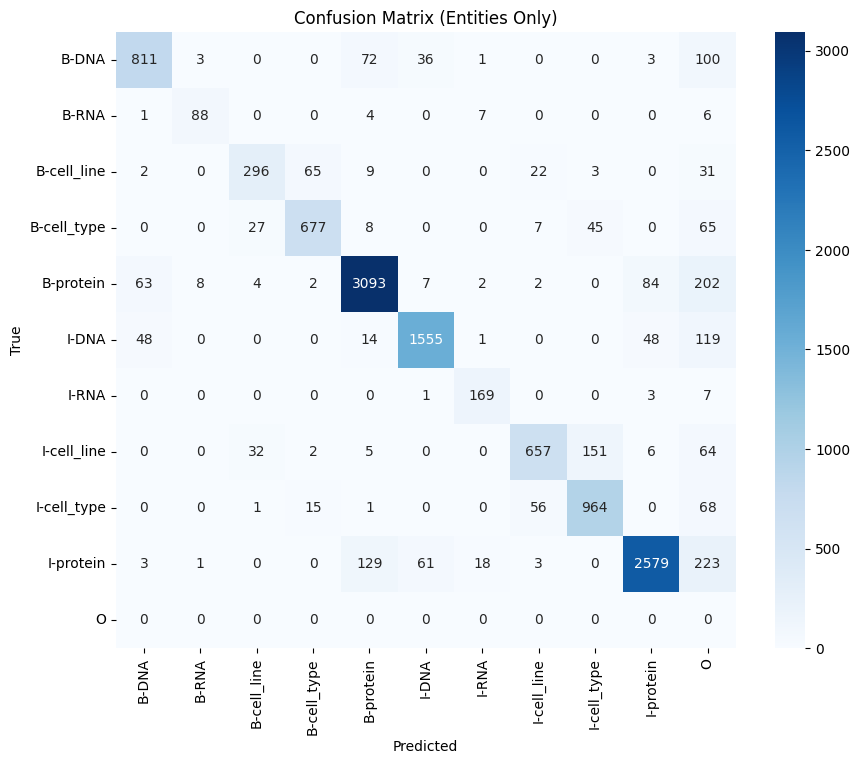

In [98]:
ckpt = torch.load("best_bioner_jnlpba.pt", map_location=device)

model.load_state_dict(ckpt["model_state"])
model.to(device)
model.eval()

label_vocab_1 = ckpt["label_vocab"]
id2label = {v: k for k, v in label_vocab_1.items()}

y_true, y_pred = collect_predictions(
    model,
    test_loader_jnlpba,
    label_vocab_1,
    device
)

plot_confusion_matrix(y_true, y_pred, label_vocab_1)

### Prediction

In [31]:
def predict_sentence(model, sentence_tokens, word_vocab, char_vocab, id2label, max_char_len=30):
    """
    Predict labels for a single tokenized sentence.
    sentence_tokens: list of strings
    """
    model.eval()

    # Encode words
    words = [word_vocab.get(w, word_vocab["<UNK>"]) for w in sentence_tokens]
    
    # Encode characters
    chars = []
    for w in sentence_tokens:
        c = [char_vocab.get(ch, char_vocab["<UNK>"]) for ch in w][:max_char_len]
        c += [char_vocab["<PAD>"]] * (max_char_len - len(c))
        chars.append(c)

    # Convert to tensors
    w_tensor = torch.tensor([words]).to(device)
    c_tensor = torch.tensor([chars]).to(device)
    mask = torch.tensor([[1]*len(words)], dtype=torch.bool).to(device)

    # Get predictions
    with torch.no_grad():
        preds = model(w_tensor, c_tensor, mask)  # returns list of lists

    # Map ids to labels
    pred_labels = [id2label[i] for i in preds[0]]
    return pred_labels


In [90]:
all_gold, all_pred = [], []

with torch.no_grad():
    for w, c, l, m in test_loader_jnlpba:
        w, c, l, m = w.to(device), c.to(device), l.to(device), m.to(device)
        preds = model(w, c, m)
        for p, g, mask in zip(preds, l, m):
            L = mask.sum().item()
            all_pred.append(p[:L])
            all_gold.append(g[:L].tolist())

# Convert predicted IDs to labels for first few sentences
for i in range(3):
    pred_labels = [id2label[x] for x in all_pred[i]]
    gold_labels = [id2label[x] for x in all_gold[i]]
    print(f"Sentence {i+1}:")
    print("Pred:", pred_labels)
    print("Gold:", gold_labels)
    print()


Sentence 1:
Pred: ['O', 'O', 'O', 'O', 'O', 'O', 'B-protein', 'O', 'O', 'O', 'B-protein', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DNA', 'I-DNA', 'O', 'B-protein', 'O']
Gold: ['O', 'O', 'O', 'O', 'O', 'O', 'B-protein', 'O', 'O', 'O', 'B-protein', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-protein', 'O', 'O', 'B-protein', 'O']

Sentence 2:
Pred: ['O', 'O', 'O', 'O', 'B-protein', 'O']
Gold: ['O', 'O', 'O', 'O', 'B-protein', 'O']

Sentence 3:
Pred: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DNA', 'I-DNA', 'I-DNA', 'I-DNA', 'I-DNA', 'I-DNA', 'O', 'O', 'O']
Gold: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-protein', 'I-protein', 'O', 'O', 'B-protein', 'I-protein', 'O', 'O', 'O']



In [91]:
# Load trained model
ckpt = torch.load("best_bioner_jnlpba.pt", map_location=device)

word_vocab  = ckpt["word_vocab"]
char_vocab  = ckpt["char_vocab"]
label_vocab = ckpt["label_vocab"]
id2label = {v: k for k, v in label_vocab.items()}

model = BioNER(label_vocab=label_vocab_jnlpba, fc_activation=None).to(device)
model.load_state_dict(ckpt["model_state"], strict= False)
model.eval()

# Extended test sentences covering all classes and tricky cases
test_data = [
    # Protein + Cell line
    (
        ["Octamer-binding", "proteins", "from", "HeLa", "cells", "stimulate", "transcription"],
        ["B-protein", "I-protein", "O", "B-cell_line", "I-cell_line", "O", "O"]
    ),
    # DNA example
    (
        ["The", "BRCA1", "gene", "is", "associated", "with", "breast", "cancer"],
        ["O", "B-DNA", "O", "O", "O", "O", "B-cell_type", "O"]
    ),
    # RNA example
    (
        ["mRNA", "expression", "in", "Jurkat", "cells", "was", "upregulated"],
        ["B-RNA", "O", "O", "B-cell_line", "I-cell_line", "O", "O"]
    ),
    # Cell type example
    (
        ["T", "lymphocytes", "play", "a", "key", "role", "in", "immune", "response"],
        ["B-cell_type", "I-cell_type", "O", "O", "O", "O", "O", "O", "O"]
    ),
    # Overlapping adjacent entities
    (
        ["p53", "and", "BRCA1", "regulate", "DNA", "replication"],
        ["B-protein", "O", "B-DNA", "O", "B-DNA", "O"]
    ),
    # Mixed entities
    (
        ["The", "RNA", "of", "Jurkat", "T", "cells", "is", "similar", "to", "HeLa", "cells"],
        ["O", "B-RNA", "O", "B-cell_line", "B-cell_type", "I-cell_line", "O", "O", "O", "B-cell_line", "I-cell_line"]
    ),
    # Long sentence with multiple types
    (
        ["p53", "protein", "binds", "to", "BRCA1", "DNA", "in", "HeLa", "and", "Jurkat", "cells", "during", "transcription"],
        ["B-protein", "I-protein", "O", "O", "B-DNA", "I-DNA", "O", "B-cell_line", "O", "B-cell_line", "I-cell_line", "O", "O"]
    ),
    # DNA + RNA + protein in one sentence
    (
        ["BRCA1", "gene", "transcribes", "mRNA", "which", "produces", "p53", "protein"],
        ["B-DNA", "O", "O", "B-RNA", "O", "O", "B-protein", "I-protein"]
    ),
]

# Function to evaluate a batch of sentences
# Function to evaluate a batch of sentences with global accuracy
def evaluate_batch(model, data, word_vocab, char_vocab, id2label):
    total_correct = 0
    total_tokens = 0

    for sentence, gold_labels in data:
        predicted_labels = predict_sentence(model, sentence, word_vocab, char_vocab, id2label)

        print(f"{'Token':15s} {'Gold':15s} {'Predicted':15s} {'Correct'}")
        print("-" * 60)

        correct = 0
        for tok, gold, pred in zip(sentence, gold_labels, predicted_labels):
            is_correct = gold == pred
            correct += is_correct
            print(f"{tok:15s} {gold:15s} {pred:15s} {is_correct}")

        total_correct += correct
        total_tokens += len(sentence)

        accuracy = correct / len(sentence)
        print(f"\nToken accuracy (sentence): {accuracy:.2f}\n")
        print("="*60 + "\n")

    # Compute global accuracy
    global_accuracy = total_correct / total_tokens
    print(f"Global token accuracy over all sentences: {global_accuracy:.2f}")


# Run evaluation
evaluate_batch(model, test_data, word_vocab, char_vocab, id2label)

Token           Gold            Predicted       Correct
------------------------------------------------------------
Octamer-binding B-protein       B-protein       True
proteins        I-protein       I-protein       True
from            O               O               True
HeLa            B-cell_line     B-cell_line     True
cells           I-cell_line     I-cell_line     True
stimulate       O               O               True
transcription   O               O               True

Token accuracy (sentence): 1.00


Token           Gold            Predicted       Correct
------------------------------------------------------------
The             O               O               True
BRCA1           B-DNA           B-DNA           True
gene            O               I-DNA           False
is              O               O               True
associated      O               O               True
with            O               O               True
breast          B-cell_type     O        

C:\Users\oumak\AppData\Local\Temp\ipykernel_23580\4128365105.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("best_bioner_jnlpba.pt", map_location=devi

### For NCBI

In [ ]:
# -----------------------------
# Model, device
# -----------------------------
model = BioNER(label_vocab=label_vocab_ncbi, fc_activation=nn.ReLU()).to(device)

# -----------------------------
# Optimizer + L2 weight decay
# -----------------------------
l2_lambda = 5e-4
decay_params, no_decay_params = [], []

for name, param in model.named_parameters():
    if not param.requires_grad:
        continue
    if "bias" in name or "word_emb" in name or "crf" in name:
        no_decay_params.append(param)
    else:
        decay_params.append(param)

opt = optim.Adam(
    [
        {"params": decay_params, "weight_decay": l2_lambda},
        {"params": no_decay_params, "weight_decay": 0.0},
    ],
    lr=1e-3
)

scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.95)

# -----------------------------
# Training loop with tqdm
# -----------------------------
best_val_f1 = 0
wait = 0
patience = 4
num_epochs = 40

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # ---- training ----
    model.train()
    tr_loss = 0.0
    n_batches = 0

    train_iter = tqdm(train_loader_ncbi, desc="Training", leave=False)
    for w, c, l, m in train_iter:
        w, c, l, m = w.to(device), c.to(device), l.to(device), m.to(device)

        opt.zero_grad()
        loss = model(w, c, m, l)  # forward with labels
        loss.backward()
        opt.step()

        tr_loss += loss.item()
        n_batches += 1

        train_iter.set_postfix({"Batch Loss": loss.item()})

    tr_loss /= n_batches

    # ---- validation ----
    model.eval()
    val_loss = 0.0
    yt_val, yp_val = [], []
    n_val_batches = 0

    val_iter = tqdm(val_loader_ncbi, desc="Validation", leave=False)
    with torch.no_grad():
        for w, c, l, m in val_iter:
            w, c, l, m = w.to(device), c.to(device), l.to(device), m.to(device)

            # loss
            loss = model(w, c, m, l)
            val_loss += loss.item()
            n_val_batches += 1

            # decode predictions
            preds = model(w, c, m)

            # move labels/mask to CPU immediately
            l_cpu = l.cpu()
            m_cpu = m.cpu()

            for p, g, mask in zip(preds, l_cpu, m_cpu):
                L = int(mask.sum())
                yp_val.extend(p[:L])
                yt_val.extend(g[:L].tolist())

            val_iter.set_postfix({"Batch Val Loss": loss.item()})

    val_loss /= n_val_batches

    # ---- compute metrics ----
    yt_val = torch.tensor(yt_val)
    yp_val = torch.tensor(yp_val)

    O_idx = label_vocab_ncbi["O"]  # get index of 'O'
    val_acc = entity_accuracy(yt_val.numpy(), yp_val.numpy(), O_idx)


    #Ignoring O class
    entity_labels = [i for i in range(len(label_vocab_ncbi)) if i != O_idx]

    precision, recall, f1 = compute_prf(
        yt_val.numpy(),
        yp_val.numpy(),
        labels=entity_labels
    )


    current_lr = opt.param_groups[0]["lr"]
    scheduler.step()

    print(
        f"Train L {tr_loss:.4f} | "
        f"Val L {val_loss:.4f} | "
        f"Acc {val_acc:.4f} | "
        f"P {precision:.4f} R {recall:.4f} F1 {f1:.4f} | "
        f"LR {current_lr:.2e}"
    )

    # ---- early stopping (F1-based) ----
    if f1 > best_val_f1:
        best_val_f1 = f1
        wait = 0
        torch.save({
            "model_state": model.state_dict(),
            "word_vocab": word_vocab,
            "char_vocab": char_vocab,
            "label_vocab": label_vocab_ncbi
        }, "best_bioner_ncbi.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping")
            break



Epoch 1/40


Train L 53.3826 | Val L 27.5739 | Acc 0.2186 | P 0.4793 R 0.2186 F1 0.3003 | LR 1.00e-03

Epoch 2/40


Train L 22.5741 | Val L 16.4442 | Acc 0.5031 | P 0.5890 R 0.5031 F1 0.5427 | LR 9.50e-04

Epoch 3/40


Train L 15.8765 | Val L 12.6488 | Acc 0.6037 | P 0.7029 R 0.6037 F1 0.6496 | LR 9.02e-04

Epoch 4/40


Train L 12.9995 | Val L 10.8149 | Acc 0.6567 | P 0.7430 R 0.6567 F1 0.6972 | LR 8.57e-04

Epoch 5/40


Train L 11.7895 | Val L 10.1120 | Acc 0.6301 | P 0.7993 R 0.6301 F1 0.7047 | LR 8.15e-04

Epoch 6/40


Train L 10.7103 | Val L 9.6170 | Acc 0.6325 | P 0.8284 R 0.6325 F1 0.7173 | LR 7.74e-04

Epoch 7/40


Train L 10.0648 | Val L 9.2911 | Acc 0.6471 | P 0.8187 R 0.6471 F1 0.7229 | LR 7.35e-04

Epoch 8/40


Train L 9.5343 | Val L 9.2044 | Acc 0.6679 | P 0.7837 R 0.6679 F1 0.7212 | LR 6.98e-04

Epoch 9/40


Train L 9.2146 | Val L 8.8245 | Acc 0.6474 | P 0.8177 R 0.6474 F1 0.7227 | LR 6.63e-04

Epoch 10/40


Train L 8.7896 | Val L 8.8448 | Acc 0.6498 | P 0.8229 R 0.6498 F1 0.7262 | LR 6.30e-04

Epoch 11/40


Train L 8.5646 | Val L 8.6375 | Acc 0.6913 | P 0.8176 R 0.6913 F1 0.7492 | LR 5.99e-04

Epoch 12/40


Train L 8.2441 | Val L 8.6089 | Acc 0.6778 | P 0.8258 R 0.6778 F1 0.7445 | LR 5.69e-04

Epoch 13/40


Train L 7.9728 | Val L 8.6392 | Acc 0.6700 | P 0.8156 R 0.6700 F1 0.7357 | LR 5.40e-04

Epoch 14/40


Train L 7.8482 | Val L 8.6063 | Acc 0.6860 | P 0.8318 R 0.6860 F1 0.7519 | LR 5.13e-04

Epoch 15/40


Train L 7.6594 | Val L 8.4294 | Acc 0.7023 | P 0.8238 R 0.7023 F1 0.7582 | LR 4.88e-04

Epoch 16/40


Train L 7.4612 | Val L 8.5256 | Acc 0.6993 | P 0.8193 R 0.6993 F1 0.7546 | LR 4.63e-04

Epoch 17/40


Train L 7.3212 | Val L 8.3631 | Acc 0.7116 | P 0.8166 R 0.7116 F1 0.7605 | LR 4.40e-04

Epoch 18/40


Train L 7.1121 | Val L 8.3323 | Acc 0.7068 | P 0.8351 R 0.7068 F1 0.7656 | LR 4.18e-04

Epoch 19/40


Train L 6.9910 | Val L 8.7194 | Acc 0.6967 | P 0.8297 R 0.6967 F1 0.7574 | LR 3.97e-04

Epoch 20/40


Train L 6.8631 | Val L 8.5337 | Acc 0.7015 | P 0.8448 R 0.7015 F1 0.7665 | LR 3.77e-04

Epoch 21/40


Train L 6.7174 | Val L 8.5429 | Acc 0.7047 | P 0.8371 R 0.7047 F1 0.7652 | LR 3.58e-04

Epoch 22/40


Train L 6.6445 | Val L 8.5478 | Acc 0.7097 | P 0.8455 R 0.7097 F1 0.7717 | LR 3.41e-04

Epoch 23/40


Train L 6.5143 | Val L 8.5534 | Acc 0.7039 | P 0.8415 R 0.7039 F1 0.7665 | LR 3.24e-04

Epoch 24/40


Train L 6.3973 | Val L 8.5747 | Acc 0.6935 | P 0.8368 R 0.6935 F1 0.7584 | LR 3.07e-04

Epoch 25/40


Train L 6.2997 | Val L 8.6334 | Acc 0.7009 | P 0.8466 R 0.7009 F1 0.7669 | LR 2.92e-04

Epoch 26/40


Train L 6.1454 | Val L 8.7374 | Acc 0.7145 | P 0.8207 R 0.7145 F1 0.7640 | LR 2.77e-04
Early stopping


In [78]:
# Get dimension from the word embedding layer
embedding_dim = model.word_emb.embedding_dim
print("Word embedding dimension:", embedding_dim)

# If your model has an LSTM or another hidden layer
if hasattr(model, "lstm"):
    hidden_dim = model.lstm.hidden_size
    print("LSTM hidden state dimension:", hidden_dim)


Word embedding dimension: 200


In [80]:
# -----------------------------
# Test evaluation (NO training)
# -----------------------------
model = BioNER(label_vocab=label_vocab_ncbi, fc_activation=nn.ReLU()).to(device)
ckpt = torch.load("best_bioner_ncbi.pt", map_location=device)
model.load_state_dict(ckpt["model_state"], strict=False)
model.eval()

yt_test, yp_test = [], []

with torch.no_grad():
    for w, c, l, m in test_loader_ncbi:
        w, c, l, m = w.to(device), c.to(device), l.to(device), m.to(device)
        preds = model(w, c, m)

        l_cpu = l.cpu()
        m_cpu = m.cpu()

        for p, g, mask in zip(preds, l_cpu, m_cpu):
            L = int(mask.sum())
            yp_test.extend(p[:L])
            yt_test.extend(g[:L].tolist())

yt_test = torch.tensor(yt_test)
yp_test = torch.tensor(yp_test)

O_idx = label_vocab_ncbi["O"]
entity_labels = [i for i in range(len(label_vocab_ncbi)) if i != O_idx]

precision, recall, f1 = compute_prf(
    yt_test.numpy(),
    yp_test.numpy(),
    labels=entity_labels
)

print(f"TEST Precision: {precision:.4f}")
print(f"TEST Recall:    {recall:.4f}")
print(f"TEST F1:        {f1:.4f}")


C:\Users\oumak\AppData\Local\Temp\ipykernel_23580\2119539701.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("best_bioner_ncbi.pt", map_location=device

TEST Precision: 0.8282
TEST Recall:    0.7027
TEST F1:        0.7603


In [ ]:
# ----- 1. Load label mapping -----
id2label = {v: k for k, v in label_vocab_ncbi.items()}  # assuming you have label_vocab dict

# ----- 2. Load trained model -----
model = BioNER(label_vocab=label_vocab_ncbi, fc_activation=nn.ReLU()).to(device)
ckpt = torch.load("best_bioner_ncbi.pt", map_location=device)
model.load_state_dict(ckpt["model_state"], strict=False)
model.eval()


# ----- 3. Token-wise entity metrics -----
def entity_metrics_tokenwise(y_true, y_pred, id2label):
    """
    Compute precision, recall, F1 for entity classes only (token-level).
    Class 'O' is ignored.
    """
    gold_by_type = Counter()
    pred_by_type = Counter()
    correct_by_type = Counter()

    for gt_seq, pr_seq in zip(y_true, y_pred):
        for gt_id, pr_id in zip(gt_seq, pr_seq):
            gt_label = id2label[gt_id]
            pr_label = id2label[pr_id]

            # Ignore O labels
            if gt_label != "O":
                gold_by_type[gt_label] += 1

            if pr_label != "O":
                pred_by_type[pr_label] += 1

            if gt_label == pr_label and gt_label != "O":
                correct_by_type[gt_label] += 1

    # ----- Per-class metrics -----
    results = {}
    for ent in gold_by_type:
        p = correct_by_type[ent] / (pred_by_type[ent] + 1e-8)
        r = correct_by_type[ent] / (gold_by_type[ent] + 1e-8)
        f = 2 * p * r / (p + r + 1e-8)
        results[ent] = (p, r, f)

    # ----- Overall micro metrics (entities only) -----
    tp = sum(correct_by_type.values())
    fp = sum(pred_by_type.values()) - tp
    fn = sum(gold_by_type.values()) - tp

    overall_precision = tp / (tp + fp + 1e-8)
    overall_recall = tp / (tp + fn + 1e-8)
    overall_f1 = 2 * overall_precision * overall_recall / (overall_precision + overall_recall + 1e-8)

    return overall_precision, overall_recall, overall_f1, results



# ----- 4. Run evaluation -----
def evaluate_tokenwise(model, loader, id2label):
    all_gold, all_pred = [], []

    with torch.no_grad():
        for w, c, l, m in loader:
            w, c, l, m = w.to(device), c.to(device), l.to(device), m.to(device)
            preds = model(w, c, m)

            for p, g, mask in zip(preds, l, m):
                L = mask.sum().item()
                all_pred.append(p[:L])
                all_gold.append(g[:L].tolist())

    overall_p, overall_r, overall_f, per_class = entity_metrics_tokenwise(all_gold, all_pred, id2label)
    return overall_p, overall_r, overall_f, per_class


# ----- 5. Execute evaluation -----
precision, recall, f1, per_entity = evaluate_tokenwise(model, test_loader_ncbi, id2label)

print(f"Token-level Precision: {precision:.4f}")
print(f"Token-level Recall:    {recall:.4f}")
print(f"Token-level F1:        {f1:.4f}\n")

print("Per-class metrics:")
for ent, (p, r, f) in sorted(per_entity.items()):
    print(f"{ent:12s} \t P:{p:.3f} R:{r:.3f} F1:{f:.3f}")


C:\Users\oumak\AppData\Local\Temp\ipykernel_23580\1672885676.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("best_bioner_ncbi.pt", map_location=device

Token-level Precision: 0.8282
Token-level Recall:    0.7027
Token-level F1:        0.7603

Per-class metrics:
B-CompositeMention 	 P:0.857 R:0.632 F1:0.727
B-DiseaseClass 	 P:0.701 R:0.675 F1:0.688
B-Modifier   	 P:0.894 R:0.899 F1:0.897
B-SpecificDisease 	 P:0.835 R:0.845 F1:0.840
I-CompositeMention 	 P:0.804 R:0.547 F1:0.651
I-DiseaseClass 	 P:0.759 R:0.570 F1:0.651
I-Modifier   	 P:0.839 R:0.779 F1:0.808
I-SpecificDisease 	 P:0.838 R:0.681 F1:0.752


C:\Users\oumak\AppData\Local\Temp\ipykernel_23580\2687031466.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("best_bioner_ncbi.pt", map_location=device

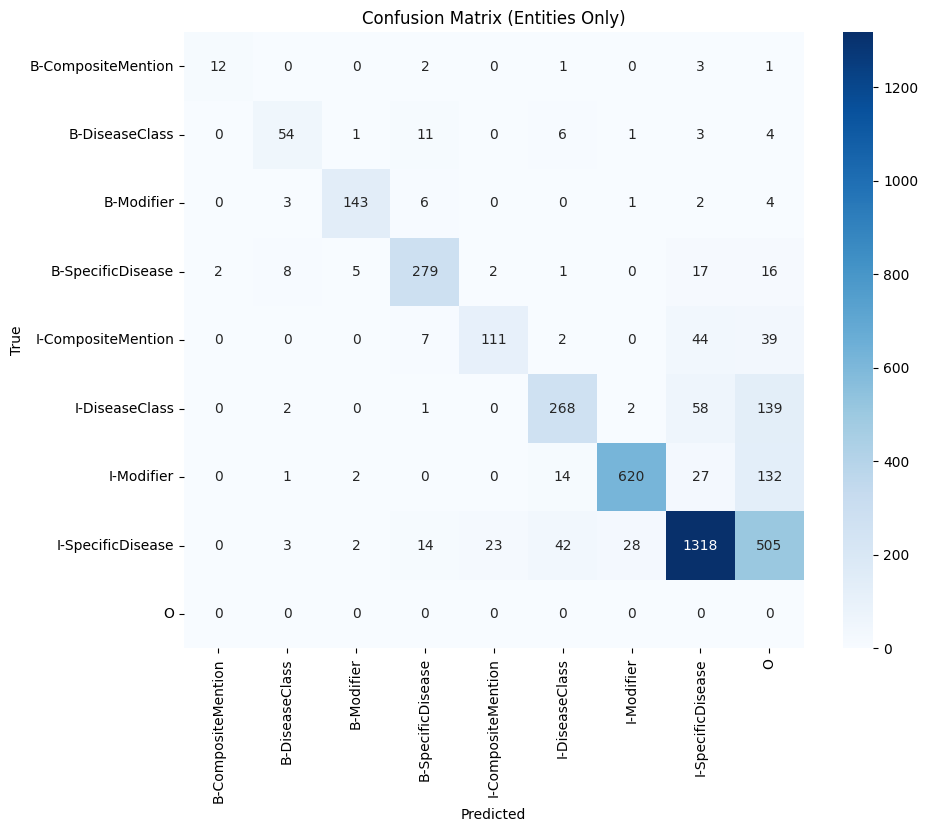

In [100]:
ckpt = torch.load("best_bioner_ncbi.pt", map_location=device)

model = BioNER(
    label_vocab=label_vocab_ncbi,
    fc_activation=torch.relu
).to(device)
model.load_state_dict(ckpt["model_state"])
model.to(device)
model.eval()

label_vocab_2 = ckpt["label_vocab"]
id2label = {v: k for k, v in label_vocab_2.items()}

y_true, y_pred = collect_predictions(
    model,
    test_loader_ncbi,
    label_vocab_2,
    device
)

plot_confusion_matrix(y_true, y_pred, label_vocab_2)

#### Prediction NCBI

In [86]:
all_gold, all_pred = [], []

with torch.no_grad():
    for w, c, l, m in test_loader_ncbi:
        w, c, l, m = w.to(device), c.to(device), l.to(device), m.to(device)
        preds = model(w, c, m)
        for p, g, mask in zip(preds, l, m):
            L = mask.sum().item()
            all_pred.append(p[:L])
            all_gold.append(g[:L].tolist())

# Convert predicted IDs to labels for first few sentences
for i in range(3):
    pred_labels = [id2label[x] for x in all_pred[i]]
    gold_labels = [id2label[x] for x in all_gold[i]]
    print(f"Sentence {i+1}:")
    print("Pred:", pred_labels)
    print("Gold:", gold_labels)
    print()


Sentence 1:
Pred: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Gold: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Sentence 2:
Pred: ['O', 'O', 'O', 'O', 'O', 'O', 'B-SpecificDisease', 'I-SpecificDisease', 'I-SpecificDisease', 'I-SpecificDisease', 'I-SpecificDisease', 'I-SpecificDisease', 'O', 'O', 'O', 'O', 'O', 'O']
Gold: ['O', 'O', 'O', 'O', 'O', 'O', 'B-SpecificDisease', 'I-SpecificDisease', 'I-SpecificDisease', 'I-SpecificDisease', 'I-SpecificDisease', 'I-SpecificDisease', 'O', 'O', 'O', 'O', 'O', 'O']

Sentence 3:
Pred: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Gold: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']



In [38]:
# -----------------------------
# Load model checkpoint
# -----------------------------
ckpt = torch.load("best_bioner_ncbi.pt", map_location=device)

word_vocab  = ckpt["word_vocab"]
char_vocab  = ckpt["char_vocab"]
label_vocab = ckpt["label_vocab"]
id2label = {v: k for k, v in label_vocab.items()}

# Create model
model = BioNER(label_vocab=label_vocab, fc_activation=nn.ReLU()).to(device)
model.load_state_dict(ckpt["model_state"], strict=False)
model.eval()

print("Labels:", list(label_vocab.keys()))

# -----------------------------
# Example test data
# -----------------------------
test_data = [
    # Composite mention: "Acute myeloid leukemia"
    (
        ["Acute", "myeloid", "leukemia", "patients", "show", "high", "expression"],
        ["B-Modifier", "I-CompositeMention", "I-CompositeMention", "O", "O", "O", "O"]
    ),
    
    # Specific disease: "Breast cancer"
    (
        ["Breast", "cancer", "is", "common", "in", "women"],
        ["B-SpecificDisease", "I-SpecificDisease", "O", "O", "O", "O"]
    ),
    
    # Disease class: "chronic inflammatory disease"
    (
        ["Chronic", "inflammatory", "disease", "affects", "the", "gut"],
        ["B-Modifier", "I-Modifier", "B-DiseaseClass", "O", "O", "O"]
    ),
    
    # Modifier only: "Severe acute"
    (
        ["Severe", "acute", "symptoms", "require", "hospitalization"],
        ["B-Modifier", "I-Modifier", "O", "O", "O"]
    ),
    
    # Single token entities: "Diabetes" and "disease"
    (
        ["Diabetes", "is", "a", "common", "disease"],
        ["B-SpecificDisease", "O", "O", "O", "B-DiseaseClass"]
    ),
    
    # All O tokens (no entities)
    (
        ["Patients", "show", "no", "signs", "of", "infection"],
        ["O", "O", "O", "O", "O", "O"]
    ),
    
    # Composite + Modifier example: "Autoimmune polyendocrine syndrome type 1"
    (
        ["Autoimmune", "polyendocrine", "syndrome", "type", "1", "is", "rare"],
        ["B-Modifier", "I-CompositeMention", "I-CompositeMention", "I-CompositeMention", "I-CompositeMention", "O", "O"]
    ),
    
    # Specific disease + Modifier: "Severe acute respiratory syndrome"
    (
        ["Severe", "acute", "respiratory", "syndrome", "patients", "require", "hospitalization"],
        ["B-Modifier", "I-Modifier", "B-SpecificDisease", "I-SpecificDisease", "O", "O", "O"]
    ),
]


# -----------------------------
# Evaluate batch
# -----------------------------
def evaluate_batch(model, data, word_vocab, char_vocab, id2label):
    all_gold = []
    all_pred = []

    for sentence, gold_labels in data:
        pred_labels = predict_sentence(model, sentence, word_vocab, char_vocab, id2label)

        print(f"{'Token':15s} {'Gold':25s} {'Predicted':25s} {'Correct'}")
        print("-"*80)
        correct = 0
        for tok, gold, pred in zip(sentence, gold_labels, pred_labels):
            is_correct = gold == pred
            correct += is_correct
            print(f"{tok:15s} {gold:25s} {pred:25s} {is_correct}")

            # Only consider entity labels for global metrics
            if gold != "O":
                all_gold.append(gold)
                all_pred.append(pred)

        acc_sent = correct / len(sentence)
        print(f"\nToken accuracy (sentence, incl. O): {acc_sent:.2f}")
        print("="*80 + "\n")

    # Compute global metrics ignoring 'O'
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_gold, all_pred, labels=[l for l in label_vocab if l != "<PAD>" and l != "O"], average='weighted'
    )
    print(f"Global token metrics (entities only, ignoring O):")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")

# -----------------------------
# Run evaluation
# -----------------------------
evaluate_batch(model, test_data, word_vocab, char_vocab, id2label)


Labels: ['<PAD>', 'B-CompositeMention', 'B-DiseaseClass', 'B-Modifier', 'B-SpecificDisease', 'I-CompositeMention', 'I-DiseaseClass', 'I-Modifier', 'I-SpecificDisease', 'O']
Token           Gold                      Predicted                 Correct
--------------------------------------------------------------------------------
Acute           B-Modifier                O                         False
myeloid         I-CompositeMention        B-Modifier                False
leukemia        I-CompositeMention        I-Modifier                False
patients        O                         I-Modifier                False
show            O                         I-Modifier                False
high            O                         I-Modifier                False
expression      O                         I-Modifier                False

Token accuracy (sentence, incl. O): 0.00

Token           Gold                      Predicted                 Correct
---------------------------------

C:\Users\oumak\AppData\Local\Temp\ipykernel_25188\97974227.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("best_bioner_ncbi.pt", map_location=device)
